In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import ipywidgets as widgets
import random

def set_all_seeds(seed=42):
    random.seed(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)

In [13]:
feature_names={
    1: "ISOTOPE",
    2: "103 < ATOMIC NO. < 256",
    3: "GROUP IVA,VA,VIA PERIODS 4-6 (Ge...)",
    4: "ACTINIDE",
    5: "GROUP IIIB,IVB (Sc...)",
    6: "LANTHANIDE",
    7: "GROUP VB,VIB,VIIB (V...)",
    8: "QAAA@1",
    9: "GROUP VIII (Fe...)",
    10: "GROUP IIA (ALKALINE EARTH)",
    11: "4M RING",
    12: "GROUP IB,IIB (Cu...)",
    13: "ON(C)C",
    14: "S-S",
    15: "OC(O)O",
    16: "QAA@1",
    17: "CTC",
    18: "GROUP IIIA (B...)",
    19: "7M RING",
    20: "SI",
    21: "C=C(Q)Q",
    22: "3M RING",
    23: "NC(O)O",
    24: "N-O",
    25: "NC(N)N",
    26: "C$=C($A)$A",
    27: "I",
    28: "QCH2Q",
    29: "P",
    30: "CQ(C)(C)A",
    31: "QX",
    32: "CSN",
    33: "NS",
    34: "CH2=A",
    35: "GROUP IA (ALKALI METAL)",
    36: "S HETEROCYCLE",
    37: "NC(O)N",
    38: "NC(C)N",
    39: "OS(O)O",
    40: "S-O",
    41: "CTN",
    42: "F",
    43: "QHAQH",
    44: "OTHER",
    45: "C=CN",
    46: "BR",
    47: "SAN",
    48: "OQ(O)O",
    49: "CHARGE",
    50: "C=C(C)C",
    51: "CSO",
    52: "NN",
    53: "QHAAAQH",
    54: "QHAAQH",
    55: "OSO",
    56: "ON(O)C",
    57: "O HETEROCYCLE",
    58: "QSQ",
    59: "Snot%A%A",
    60: "S=O",
    61: "AS(A)A",
    62: "A$A!A$A",
    63: "N=O",
    64: "A$A!S",
    65: "C%N",
    66: "CC(C)(C)A",
    67: "QS",
    68: "QHQH (&...)",
    69: "QQH",
    70: "QNQ",
    71: "NO",
    72: "OAAO",
    73: "S=A",
    74: "CH3ACH3",
    75: "A!N$A",
    76: "C=C(A)A",
    77: "NAN",
    78: "C=N",
    79: "NAAN",
    80: "NAAAN",
    81: "SA(A)A",
    82: "ACH2QH",
    83: "QAAAA@1",
    84: "NH2",
    85: "CN(C)C",
    86: "CH2QCH2",
    87: "X!A$A",
    88: "S",
    89: "OAAAO",
    90: "QHAACH2A",
    91: "QHAAACH2A",
    92: "OC(N)C",
    93: "QCH3",
    94: "QN",
    95: "NAAO",
    96: "5M RING",
    97: "NAAAO",
    98: "QAAAAA@1",
    99: "C=C",
    100: "ACH2N",
    101: "8M RING",
    102: "QO",
    103: "CL",
    104: "QHACH2A",
    105: "A$A($A)$A",
    106: "QA(Q)Q",
    107: "XA(A)A",
    108: "CH3AAACH2A",
    109: "ACH2O",
    110: "NCO",
    111: "NACH2A",
    112: "AA(A)(A)A",
    113: "Onot%A%A",
    114: "CH3CH2A",
    115: "CH3ACH2A",
    116: "CH3AACH2A",
    117: "NAO",
    118: "ACH2CH2A > 1",
    119: "N=A",
    120: "HETEROCYCLIC ATOM > 1 (&...)",
    121: "N HETEROCYCLE",
    122: "AN(A)A",
    123: "OCO",
    124: "QQ",
    125: "AROMATIC RING > 1",
    126: "A!O!A",
    127: "A$A!O > 1 (&...)",
    128: "ACH2AAACH2A",
    129: "ACH2AACH2A",
    130: "QQ > 1 (&...)",
    131: "QH > 1",
    132: "OACH2A",
    133: "A$A!N",
    134: "X (HALOGEN)",
    135: "Nnot%A%A",
    136: "O=A > 1",
    137: "HETEROCYCLE",
    138: "QCH2A > 1 (&...)",
    139: "OH",
    140: "O > 3 (&...)",
    141: "CH3 > 2 (&...)",
    142: "N > 1",
    143: "A$A!O",
    144: "Anot%A%Anot%A",
    145: "6M RING > 1",
    146: "O > 2",
    147: "ACH2CH2A",
    148: "AQ(A)A",
    149: "CH3 > 1",
    150: "A!A$A!A",
    151: "NH",
    152: "OC(C)C",
    153: "QCH2A",
    154: "C=O",
    155: "A!CH2!A",
    156: "NA(A)A",
    157: "C-O",
    158: "C-N",
    159: "O > 1",
    160: "CH3",
    161: "N",
    162: "AROMATIC",
    163: "6M RING",
    164: "O",
    165: "RING",
    166: "FRAGMENTS"
}.values()

In [14]:
class HGNAM(nn.Module):
    def __init__(
          self,
          in_channels,
          out_channels,
          num_layers,
          hidden_channels=None,
          bias=True,
          dropout=0.0,
          device='cuda',
          limited_m=True,
          normalize_m=True,
          m_per_feature=False,
          weight = False,
          aggregation = "overall"
    ):
        
        super().__init__()
        self.device = device
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.bias = bias
        self.dropout = dropout
        self.limited_m = limited_m
        self.normalize_m = normalize_m
        self.m_per_feature = m_per_feature
        self.weight = weight
        self.aggregation = aggregation
        if self.weight == True:
            self.feature_weights = nn.Parameter(torch.rand(self.in_channels))

        # shape functions f_k
        self.fs = nn.ModuleList()
        for _ in range(in_channels):
            if num_layers == 1:
                layers = [nn.Linear(1, out_channels, bias=bias)]
            else:
                layers = [nn.Linear(1, hidden_channels, bias=bias), nn.ReLU(), nn.Dropout(p=dropout)]
                for _ in range(1, num_layers - 1):
                    layers += [nn.Linear(hidden_channels, hidden_channels, bias=bias), nn.ReLU(), nn.Dropout(p=dropout)]
                layers.append(nn.Linear(hidden_channels, out_channels, bias=bias))
            self.fs.append(nn.Sequential(*layers))

        # distance functions \rho
        if m_per_feature:
            self.ms = nn.ModuleList()
            for _ in range(out_channels if limited_m else in_channels):
                if num_layers == 1:
                    m_layers = [nn.Linear(1, out_channels, bias=bias)]
                else:
                    m_layers = [nn.Linear(1, hidden_channels, bias=bias), nn.ReLU()]
                    for _ in range(1, num_layers - 1):
                        m_layers += [nn.Linear(hidden_channels, hidden_channels, bias=bias), nn.ReLU()]
                    if limited_m:
                        m_layers.append(nn.Linear(hidden_channels, 1, bias=bias))
                    else:
                        m_layers.append(nn.Linear(hidden_channels, out_channels, bias=bias))
                self.ms.append(nn.Sequential(*m_layers))
        else:
            if num_layers == 1:
                m_layers = [nn.Linear(1, out_channels, bias=bias)]
            else:
                m_layers = [nn.Linear(1, hidden_channels, bias=bias), nn.ReLU()]
                for _ in range(1, num_layers - 1):
                    m_layers += [nn.Linear(hidden_channels, hidden_channels, bias=bias), nn.ReLU()]
                if limited_m:
                    m_layers.append(nn.Linear(hidden_channels, 1, bias=bias))
                else:
                    m_layers.append(nn.Linear(hidden_channels, out_channels, bias=bias))
            self.m = nn.Sequential(*m_layers)

    def forward(self, inputs):
        x, distances, normalization_matrix = inputs.x.to(self.device), inputs.dist_mat.to(self.device), inputs.norm_mat.to(self.device)
        fx = torch.empty(x.size(0), x.size(1), self.out_channels).to(self.device)
        for feature_index in range(x.size(1)):
            feature_col = x[:, feature_index].view(-1, 1)
            fx[:, feature_index] = self.fs[feature_index](feature_col)
        if self.weight == True:
            attention_weights = F.softmax(torch.exp(self.feature_weights), dim=0)
            fx_weighted = fx * attention_weights.unsqueeze(0).unsqueeze(-1)  # (N, num_features, out_channels)
            f_sums = fx_weighted.sum(dim=1)
        else:
            f_sums = fx.sum(dim=1)

        if self.aggregation == "overall":
            m_dist = self.m(distances.flatten().view(-1, 1))
            m_dist = m_dist.view(distances.size(0), distances.size(1), self.out_channels)

            if self.normalize_m:
                m_dist = m_dist / normalization_matrix.unsqueeze(-1)

            output = torch.sum(m_dist * f_sums.unsqueeze(0), dim=1)

        elif self.aggregation == "neighbor":
            N = distances.size(0)
            out_channels = f_sums.size(1)
            self_embedding = f_sums

            # distinguish neighbor(distances==0.5 because distances = 1/(real distances + 1))
            neighbor_mask = (distances == 0.5)

            neighbor_indices = neighbor_mask.nonzero(as_tuple=False)

            neighbor_agg = torch.zeros((N, out_channels), device=f_sums.device)
            neighbor_agg.index_add_(0, neighbor_indices[:, 0], f_sums[neighbor_indices[:, 1]])

            neighbor_counts = neighbor_mask.float().sum(dim=1, keepdim=True)
            avg_neighbors = torch.where(neighbor_counts > 0, neighbor_agg / neighbor_counts, torch.zeros_like(neighbor_agg))
            output = self_embedding + avg_neighbors

        else:
            raise ValueError("Unknown aggregation type: {}".format(self.aggregation))
        return output

    def print_m_params(self):
        if hasattr(self, 'm'):
            print("Single m network parameters:")
            for name, param in self.m.named_parameters():
                print(name, param)
        elif hasattr(self, 'ms'):
            print("Separate m networks per dimension:")
            for idx, module in enumerate(self.ms):
                for name, param in module.named_parameters():
                    print(f"ms[{idx}].{name}", param)
        else:
            print("No m parameters found.")

In [15]:
 def compute_f_scores(model, x):
    num_samples, num_features = x.size()
    feature_results = []
    
    for feature_index in range(num_features):
        feature_input = x[:, feature_index].view(-1, 1)
        feature_output = model.fs[feature_index](feature_input)
        
        feature_input_np = feature_input.detach().cpu().numpy()
        feature_output_np = feature_output.detach().cpu().numpy()
        
        feature_results.append((feature_input_np, feature_output_np))
    
    return feature_results

In [26]:
def plot_distance(model, max_distance, data_name, save_dir='./plot'):

    sns.set_style("white")
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams.update({
        'font.size': 20,
        'font.weight': 'bold',           
        'axes.titlesize': 20,
        'axes.titleweight': 'bold',        
        'axes.labelsize': 20,
        'axes.labelweight': 'bold', 
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 18,
    })
    
    y_input_values = torch.tensor([1/(1+i) for i in range(int(max_distance.numpy()))])
    m_y_values = np.zeros(shape=(y_input_values.size(0), ))
    for i, val in enumerate(y_input_values):
        mdist = model.m.forward(val.view(-1, 1)).detach()
        m_y_values[i] = mdist

    plt.figure(figsize=(12, 6))
    x_ticks = [i for i in range(int(max_distance.numpy()))]
    plt.xticks(ticks=np.arange(0, int(max_distance.numpy()), 1))
    
    plt.xlim(0, max_distance-1)
    plt.plot(x_ticks, m_y_values, marker='o', markersize=8, linewidth=2, label="Data")
    
    plt.xlabel('Distance', size=20)
    plt.ylabel('Distance function output', size=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
 
    plt.savefig(f"{save_dir}/{data_name}_rho.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [17]:
class InteractiveShapeFunctionPlot:
    def __init__(self, model, x, weights, feature_names, data_name):
        self.model = model
        self.x = x
        self.weights = weights
        self.feature_names = list(feature_names)
        self.data_name = data_name
        self.current_fig = None
        self.dropdown = None
        self.filename_text = None
        self.save_button = None

    def compute_f_scores(self):
        num_samples, num_features = self.x.size()
        f_scores = []
        for feature_index in range(num_features):
            feature_col = self.x[:, feature_index].view(-1, 1)
            f_score_matrix = self.model.fs[feature_index](feature_col)
            f_scores.append(f_score_matrix.detach().cpu().numpy())
        return f_scores

    def plot_shape_function_for_feature(self, feature_idx):
        plt.rcParams['font.family'] = 'STIXGeneral'
        plt.rcParams['mathtext.fontset'] = 'stix'
        plt.rcParams.update({
            'font.size': 20,
            'font.weight': 'bold',           
            'axes.titlesize': 20,
            'axes.titleweight': 'bold',        
            'axes.labelsize': 20,
            'axes.labelweight': 'bold', 
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 18,
        })
        
        if feature_idx < 0 or feature_idx >= len(self.feature_names):
            print(f"Invalid index: {feature_idx}")
            return None

        feature_name = self.feature_names[feature_idx]
        f_scores = self.compute_f_scores()
        f_score_matrix = f_scores[feature_idx]

        unique_values = torch.unique(self.x[:, feature_idx]).detach().cpu().numpy()
        if len(unique_values) <= 1:
            print(f'Feature "{feature_name}" has only one feature input. Cannot be plotted!')
            return None

        sorted_unique_values = np.sort(unique_values)
        sorted_indices = np.argsort(self.x[:, feature_idx].detach().cpu().numpy())
        sorted_values = self.x[sorted_indices, feature_idx].detach().cpu().numpy()
        sorted_f_scores = f_score_matrix[sorted_indices, :]
        weight = float(self.weights[feature_idx])
        sorted_f_scores = sorted_f_scores * weight

        binned_values = sorted_unique_values
        binned_f_scores = []
        for val in binned_values:
            mask = sorted_values >= val
            binned_f_scores.append(sorted_f_scores[mask].mean(axis=0))
        binned_f_scores = np.array(binned_f_scores)

        fig, ax = plt.subplots(figsize=(10, 6))
        for channel in range(binned_f_scores.shape[1]):
            ax.step(
                binned_values,
                binned_f_scores[:, channel],
                where="post",
                label=f"Channel {channel + 1}" if binned_f_scores.shape[1] > 1 else None,
                linewidth=2
            )
        ax.set_xticks(np.arange(int(sorted_values.min()), int(sorted_values.max()) + 1, 1))
        ax.set_xlabel(f'$k$="{feature_name}"', fontsize=20)
        ax.set_ylabel('$w_kf_k$', fontsize=20)
        if binned_f_scores.shape[1] > 1:
            ax.legend(loc="best")
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        return fig

    def update_plot(self, feature_idx):
        plt.close('all')
        self.current_fig = self.plot_shape_function_for_feature(feature_idx)

    def on_save_button_clicked(self, b):
        fname = self.filename_text.value.strip()
        if not fname:
            current_feature_idx = self.dropdown.value
            current_feature_name = self.feature_names[current_feature_idx]
            fname = str(self.data_name) + '_' + str(current_feature_name)
        if self.current_fig is None:
            print("No plot is available to save.")
            return
        directory = "./plot"
        if not os.path.exists(directory):
            os.makedirs(directory)
        self.current_fig.savefig(f"{directory}/{fname}.pdf", format="pdf", bbox_inches="tight")
        print(f"Plot saved as {fname}.pdf")

    def show(self):
        options = [(f"{i}: {name}", i) for i, name in enumerate(self.feature_names)]
        self.dropdown = widgets.Dropdown(
            options=options,
            value=0,
            description='Feature:',
            disabled=False,
        )
        self.filename_text = widgets.Text(
            value='',
            placeholder='Enter file name',
            description='File Name:',
            disabled=False
        )
        self.save_button = widgets.Button(
            description="Save Plot",
            disabled=False,
            button_style='',
            tooltip='Click to save the current plot',
            icon='save'
        )
        self.save_button.on_click(self.on_save_button_clicked)

        interact_widget = widgets.interactive(self.update_plot, feature_idx=self.dropdown)
        display(interact_widget)
        display(self.filename_text, self.save_button)

In [18]:
class InteractiveHeatmap:
    def __init__(self, f_scores, m_y_values, data_name, feature_weights, index=None, feature_names=None):

        self.f_scores = self._process_f_scores(f_scores)
        self.m_y_values = m_y_values
        self.data_name = data_name
        self.feature_weights = feature_weights

        self.scores = self.f_scores[:, 0, :, :].squeeze(-1)
        self.inputs = self.f_scores[:, 1, :, :].squeeze(-1)
        self.N, self.F = self.scores.shape
        
        if index is None:
            self.index = list(range(self.F))
        else:
            self.index = index
        self.feature_names = feature_names

        self.options = []
        for idx in range(self.F):
            if self.feature_names is not None:
                orig_id = self.index[idx] + 1
                name = self.feature_names.get(orig_id, f'Feature {orig_id}')
                self.options.append((name, idx))
            else:
                self.options.append((f'Feature {idx}', idx))
                
        self.current_fig = None
        self.dropdown = None
        self.filename_text = None
        self.save_button = None
        self.current_feature_index = None

    def _process_f_scores(self, f_scores):
        if isinstance(f_scores, list):
            inputs_list = []
            scores_list = []
            for feature_input, feature_output in f_scores:
                if not torch.is_tensor(feature_input):
                    feature_input = torch.tensor(feature_input)
                if not torch.is_tensor(feature_output):
                    feature_output = torch.tensor(feature_output)
                inputs_list.append(feature_input)
                scores_list.append(feature_output)
            inputs_tensor = torch.stack(inputs_list, dim=1)
            scores_tensor = torch.stack(scores_list, dim=1)
            f_scores = torch.stack([scores_tensor, inputs_tensor], dim=1)
        return f_scores

    def _plot_feature(self, feature_index):
        plt.rcParams['font.family'] = 'STIXGeneral'
        plt.rcParams['mathtext.fontset'] = 'stix'
        plt.rcParams.update({
            'font.size': 20,
            'font.weight': 'bold',           
            'axes.titlesize': 20,
            'axes.titleweight': 'bold',        
            'axes.labelsize': 15,
            'axes.labelweight': 'bold', 
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 18,
        })
        self.current_feature_index = feature_index
        feature_inputs = self.inputs[:, feature_index]
        feature_scores = self.scores[:, feature_index]
    
        unique_vals = torch.unique(feature_inputs).sort()[0]
        unique_vals_np = unique_vals.cpu().numpy()
    
        avg_scores = []
        for uv in unique_vals:
            indices = (feature_inputs == uv)
            avg_score = feature_scores[indices].mean()
            avg_scores.append(avg_score.item())
        avg_scores = np.array(avg_scores)
    
        heatmap_data = np.outer(self.m_y_values, avg_scores)
        if torch.is_tensor(self.feature_weights):
            weight = self.feature_weights[feature_index].item()
        else:
            weight = self.feature_weights[feature_index]
        heatmap_data = heatmap_data * weight
    
        fig, ax = plt.subplots(figsize=(12, 8))
        ax = sns.heatmap(
            heatmap_data,
            cmap="RdYlGn",
            center=0,
            xticklabels=[f"{v:.2f}" for v in unique_vals_np],
            yticklabels=[f"{v}" for v in range(len(self.m_y_values))],
            annot=True,
            fmt=".3f",
            linewidths=0.0,
            linecolor="black",
            square=True,
            cbar_kws={"shrink": 0.7},
            annot_kws={"size": 14}
        )
        if self.feature_names is not None:
            orig_id = self.index[feature_index] + 1
            name = self.feature_names.get(orig_id, f'Feature {orig_id}')
            plt.title(f'{name} Heatmap')
        else:
            plt.title(f'Feature {feature_index} Heatmap')
        plt.xlabel('Feature Values', fontsize=20)
        plt.ylabel('Distance', fontsize=20)
        plt.tight_layout()
        plt.show()
        return fig
    
    def update_plot(self, feature_index):
        plt.close('all')
        self.current_fig = self._plot_feature(feature_index)

    def on_save_button_clicked(self, b):
        fname = self.filename_text.value.strip()
        if not fname:
            if self.feature_names is not None:
                orig_id = self.index[self.dropdown.value] + 1
                feature_name = self.feature_names.get(orig_id, f'Feature {orig_id}')
            else:
                feature_name = f'Feature_{self.dropdown.value}'
            fname = f"{self.data_name}_{feature_name}_heatmap"
        if self.current_fig is None:
            print("No plot is available to save.")
            return
        directory = "./plot"
        if not os.path.exists(directory):
            os.makedirs(directory)
        self.current_fig.savefig(f"{directory}/{fname}.pdf", format="pdf", bbox_inches="tight")
        print(f"Plot saved as {fname}.pdf")

    def show(self):
        self.dropdown = widgets.Dropdown(options=self.options, description='Feature:')
        self.filename_text = widgets.Text(
            value='',
            placeholder='Enter file name',
            description='File Name:',
            disabled=False
        )
        self.save_button = widgets.Button(
            description="Save Plot",
            disabled=False,
            button_style='',
            tooltip='Click to save the current plot',
            icon='save'
        )
        self.save_button.on_click(self.on_save_button_clicked)
        
        interact_widget = widgets.interactive(self.update_plot, feature_index=self.dropdown)
        display(interact_widget)
        display(self.filename_text, self.save_button)


In [19]:
data_name = 'iAF1260b'
data_path = f'processed_data/{data_name}.pt'
save_dir = './plot'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
data = torch.load(data_path, weights_only=False)

model_dict = 'models/iAF1260b_EdgeHGNAM_9225_best_val_acc.pt'
model = HGNAM(in_channels=167, hidden_channels=32, num_layers=3, out_channels=1, dropout=0.5, limited_m=0, bias=True, normalize_m=1, weight=True, aggregation='overall')
model.load_state_dict(torch.load(f"{model_dict}", map_location=torch.device('cuda'), weights_only=False))

num_classes = 2
num_features = data.x.size(-1)

max_distance = 1 / torch.min(data.dist_mat[data.dist_mat>0])

y_input_values = torch.tensor([1/(1+i) for i in range(int(max_distance.numpy()))])
m_y_values = np.zeros(shape=(y_input_values.size(0), ))
for i, val in enumerate(y_input_values):
        mdist = model.m.forward(val.view(-1, 1)).detach()
        m_y_values[i] = mdist

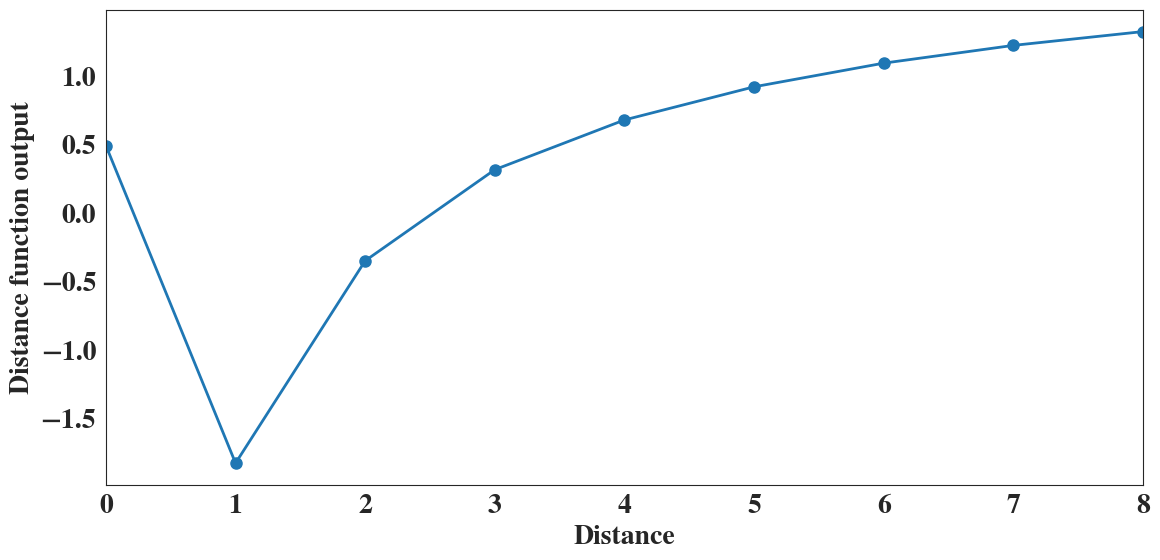

In [27]:
# Distance function
plot_distance(model,max_distance,data_name, save_dir)

In [21]:
# w_k * f_k
attention_weights = F.softmax(torch.exp(model.feature_weights), dim=0)
isp = InteractiveShapeFunctionPlot(model, data.x, attention_weights, feature_names, data_name)
isp.show()

interactive(children=(Dropdown(description='Feature:', options=(('0: ISOTOPE', 0), ('1: 103 < ATOMIC NO. < 256…

Text(value='', description='File Name:', placeholder='Enter file name')

Button(description='Save Plot', icon='save', style=ButtonStyle(), tooltip='Click to save the current plot')

In [22]:
# Plot heatmap: \rho * w_k * f_k
f_scores = compute_f_scores(model, data.x)
feature_names_dict = dict(enumerate(feature_names, start=1))

heatmap_interactive = InteractiveHeatmap(f_scores, m_y_values, data_name=data_name, feature_weights=attention_weights, feature_names=feature_names_dict)
heatmap_interactive.show()

interactive(children=(Dropdown(description='Feature:', options=(('ISOTOPE', 0), ('103 < ATOMIC NO. < 256', 1),…

Text(value='', description='File Name:', placeholder='Enter file name')

Button(description='Save Plot', icon='save', style=ButtonStyle(), tooltip='Click to save the current plot')